<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Preliminaries</a></span></li></ul></li><li><span><a href="#Process-MIRI-visit-with-Grizli" data-toc-modified-id="Process-MIRI-visit-with-Grizli-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Process MIRI visit with Grizli</a></span><ul class="toc-item"><li><span><a href="#Query-MAST-for-JWST-exposures" data-toc-modified-id="Query-MAST-for-JWST-exposures-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Query MAST for JWST exposures</a></span></li></ul></li><li><span><a href="#Grizli-Pipeline" data-toc-modified-id="Grizli-Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grizli Pipeline</a></span></li></ul></div>

## Preliminaries

Install dependencies when running on a remote server, e.g., GoogleColab.

In [122]:
# Work space, can be elsewhere
import os

if os.path.exists('/GrizliImaging'):
    WORKING_DIRECTORY = '/GrizliImaging/PipelineDemo'
else:
    WORKING_DIRECTORY = os.getcwd()

print('WORKING_DIRECTORY = ', WORKING_DIRECTORY)

if not os.path.exists(WORKING_DIRECTORY):
    os.makedirs(WORKING_DIRECTORY)
    
os.chdir(WORKING_DIRECTORY)

WORKING_DIRECTORY =  /GrizliImaging/PipelineDemo


In [123]:
# Grizli
import importlib
import sys

# Grizli and requirements, e.g., on google collab
try:
    import grizli
except:
    ! git clone https://github.com/gbrammer/grizli.git
    os.chdir('grizli')
    ! pip install -e ./ -r requirements.txt
    
    ! pip install pytest
    # Fetches config files
    ! pytest --disable-warnings
    
    os.chdir(WORKING_DIRECTORY)
    
## Module versions
print(sys.version + '\n')

for module in ['grizli', 'tristars', 'mastquery', 'sep',
               'numpy', 'scipy', 'astropy', 'astroquery', 
               'shapely', 'drizzlepac']:
    #print(module)
    try:
        mod = importlib.import_module(module)
        print('{0:>20} : {1}'.format(module, mod.__version__))
    except ModuleNotFoundError:
        print('{0:>20} : {1}'.format(module, '*failed*'))


3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:52) 
[Clang 13.0.1 ]

              grizli : 1.6.0.dev44
            tristars : 0.1
           mastquery : 1.4
                 sep : 1.2.1
               numpy : 1.23.1
               scipy : 1.9.0
             astropy : 5.1
          astroquery : 0.4.6
             shapely : 1.8.2
          drizzlepac : 3.4.2


In [124]:
try:
    import jwst
except ModuleNotFoundError:
    ! pip install jwst

if os.getenv('CRDS_PATH') is None:
    cache_dir = os.path.join(os.getcwd(), 'crds_cache')
    print(f'Set CRDS_PATH={cache_dir}')
    os.environ['CRDS_PATH'] = cache_dir
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
else:
    print(f"CRDS_PATH={os.getenv('CRDS_PATH')}")

if os.getenv('CRDS_SERVER_URL') is None:
    server = 'https://jwst-crds.stsci.edu'
    print(f'Set CRDS_SERVER_URL={server}')
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
else:
    print(f"CRDS_SERVER_URL={os.getenv('CRDS_SERVER_URL')}")


CRDS_PATH=/Users/gbrammer/Research/grizli/crds_cache
CRDS_SERVER_URL=https://jwst-crds.stsci.edu


# Process MIRI visit with Grizli

 1. Query the MAST database to find exposures
 2. Run the grizli pipeline to process exposures
 3. Make image Mosaic

In [125]:
import numpy as np
import astropy.units as u

import mastquery
from mastquery import overlaps, query, jwst
import astropy.time

from importlib import reload
reload(jwst)

import grizli
from grizli import utils, jwst_utils
from grizli.aws import db

utils.set_warnings()
jwst_utils.set_quiet_logging()

import logging
logging.basicConfig(level=logging.INFO,
                    handlers=[logging.StreamHandler(),
                              logging.FileHandler('/tmp/mastquery.log')], 
                    format = "%(module)s.%(funcName)s : %(levelname)s : %(message)s")



## Query MAST for JWST exposures

In [126]:
# CEERS
filters = []
#filters += jwst.make_program_filter([1345]) 
filters += jwst.make_program_filter([2736]) 
filters += jwst.make_query_filter('productLevel', values=['2a','2b'])

# Limited filters
filters += jwst.make_query_filter('filter', values=['F444W','F770W','F1000W'])

res = jwst.query_all_jwst(instruments=['MIR','NRC','NIS','NRS'],
                          recent_days=None, filters=filters, columns='*',
                          extensions=['rate','cal', 'rateints'])
len(res)

jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
2022-09-30 15:53:40,068 - stpipe - WARNING - No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : Available extensions are []
2022-09-30 15:53:40,070 - stpipe - WARNING - Available extensions are []
jwst.query_jwst : WARNING : Available extensions are []
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
2022-09-30 15:53:40,718 - stpipe - WARNING - No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : No files with extensions ['rate', 'cal', 'rateints'] found.
jwst.query_jwst : WARNING : Available extensions are []
2022-09-30 15:53:40,720 - stpipe - WARNING - Available extensions are []
jwst.query_jwst : WARNING : Available extensions are []


64

In [127]:
# For the demo, just include exposures on the SMACS0723 cluster field
with_cluster = np.zeros(len(res), dtype=bool)

ra, dec = 110.80542539655173, -73.45854293103446

for i, fp in enumerate(res['footprint']):
    sr = utils.SRegion(fp)
    with_cluster[i] = sr.path[0].contains_point((ra, dec))

res = res[with_cluster]

In [128]:
# Some fixes to the query

# No spaces in target names
res['targname'] = [t.replace(' ','-') for t in res['targname']]
res['target'] = [t.replace(' ','-') for t in res['target']]
res = res[np.in1d(res['instrument_name'], ['NIRISS','NIRCAM','MIRI'])]

# No MIRI spec
res = res[res['inst-mode'] != 'MIRI-None']
res = res[res['targname'] != 'MIRI-SLEW-TO-HOT-TARGET-NORTH']

# Just get rate images
for k in ['dataURI','dataURL']:
    col = res[k].tolist()
    for i, val in enumerate(col):
        col[i] = val.replace('_cal.fits','_rate.fits').replace('_rateints','_rate')
    
    res.remove_column(k)
    res[k] = col

# Unique filename, since could have found cal and rate files for the same dataset
un = utils.Unique(res['dataURL'], verbose=False)

keep = res['exptime'] > 0
for i in np.where(np.array(un.counts) > 1)[0]:
    vi = un.values[i]
    j = np.where(un[vi])[0][1:]
    keep[j] = False

# Skip some modes
mask_mode = utils.column_string_operation(res['inst-mode'], ['MASK','WLP',
                                                             'FND','P750L',
                                                             '1065C','2100C','2300C','1550C','1140C',
                                                             #'GR1','GRIS',
                                                             'W2',
                                                             'GR700','MP','WP','NRM',
                                                             'F212N'],
                                          method='count')
keep &= ~mask_mode

if 0:
    keep &= res['instrument_name'] == 'NIRCAM'
    
res = res[keep]
len(res)

29

In [129]:
# Query summary
import yaml
from grizli import utils

pi = utils.Unique(res['prog_pi'])
pi.exptime = np.array([res['effexptm'][pi[p]].sum() for p in pi.values])

js = {}

for ii in np.argsort(pi.counts):
    p = pi.values[ii]
    targs = np.unique(res['targname'][pi[p]])
    modes = np.unique(res['inst-mode'][pi[p]])
    js[str(p)] = {'N':int(pi.counts[ii]),
             'title': str(res['title'][pi[p]][0].strip()), 
             'targets': [str(t).strip() for t in targs],
             'modes': [str(t).strip() for t in modes]}
    
    print(f"\n ({js[p]['N']}) {p}  | \"{js[p]['title']}\"")
    print(f"   Targets:  {', '.join(js[p]['targets'])}")
    print(f"   Modes:    {', '.join(js[p]['modes'])}")

   N  value     
====  ==========
  29   COM-2736 Pontoppidan, Klaus M.

 (29)  COM-2736 Pontoppidan, Klaus M.  | "JWST Early Release Observation 10"
   Targets:  SMACS-J0723.3-7327
   Modes:    MIRI-F1000W, MIRI-F770W, NIRCAM-F444W


Iter #1, N_Patch = 1


 1 j072320m7327 110.82737410344828 -73.45429421551725
      target      
------------------
SMACS-J0723.3-7327 

filter j072320m7327        MIRI MI.F1000W   10    5577.8
filter j072320m7327         MIRI MI.F770W   10    5577.8
filter j072320m7327       NIRCAM NC.F444W    9    7537.2


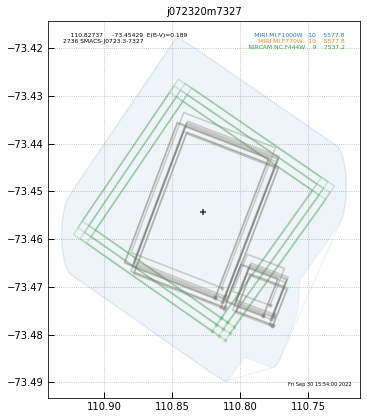

In [130]:
# Split into overlapping fields
import os
import mastquery.utils
reload(mastquery.utils); reload(overlaps)

tabs = overlaps.find_overlaps(res, use_parent=True, buffer_arcmin=0.5, close=False)

In [133]:
! ls -1 *footprint.fits

j072320m7327_footprint.fits


# Grizli Pipeline

In [135]:
# MAST_TOKEN needed for downloading files
# see https://auth.mast.stsci.edu/token
if os.getenv('MAST_TOKEN') is None:
    raise OSError('MAST_TOKEN environment variable must be set')

In [136]:
from grizli.pipeline import auto_script
kws = auto_script.get_yml_parameters()

# Stop after exposure preprocessing
kws['kill'] = 'preprocess'

In [137]:
# Explicitly set CRDS_CONTEXT
os.environ['CRDS_CONTEXT'] = 'jwst_0988.pmap'

In [138]:
# First do NIRCam
os.chdir(WORKING_DIRECTORY)

# The pointing name found above
root = 'j072320m7327'

kws['filters'] = ['F444W']

# Run the pipeline
existing_files = glob.glob(os.path.join(WORKING_DIRECTORY, root, 'RAW/*rate.fits'))
if len(existing_files) > 0:
    kws['fetch_files_args'] = None

auto_script.go(root, **kws)

# (2022-09-30 13:55:46.119)

auto_script.parse_visits(**{'files': [], 'field_root': 'j072320m7327', 'RAW_PATH': '/GrizliImaging/PipelineDemo/j072320m7327/RAW', 'use_visit': True, 'combine_same_pa': False, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F444W'], 'max_dt': 1.0, 'visit_split_shift': 1.5, 'file_query': '*'})

SMACS-J0723.3-7327-02736-001-145.0-NRCB5-F444W-CLEAR 9
** Combine Singles: **
0 smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear 9

 == Grism groups ==

# (2022-09-30 13:55:46.567)

auto_script.preprocess(**{'field_root': 'j072320m7327', 'HOME_PATH': '/GrizliImaging/PipelineDemo', 'PERSIST_PATH': '/GrizliImaging/PipelineDemo/j072320m7327/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': None, 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'alig

True

In [139]:
# Fine alignment
! cat *f444w*shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw02736001001_02105_00001_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00002_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00003_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00004_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00005_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00006_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00007_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00008_nrcblong_rate.fits'] = []
# match['jw02736001001_02105_00009_nrcblong_rate.fits'] = []
jw02736001001_02105_00001_nrcblong_rate.fits  -0.000   0.000  0.00000  1.00000   100  0.000  0.000
jw02736001001_02105_00002_nrcblong_rate.fits  -0.233  -0.037  0.00000  1.00000    73  0.101  0.097
jw02736001001_02105_00003_nrcblong_rate.fits  -0.024  -0.071  0.00000  1.00000    73  0.095  0.094
jw02736001001_02105_00004_nrcblong_rate.fits  -0.111  -0.069  0.00000  1.00000    81  0.086  0.0

In [140]:
# Global alignment
# Not ideal for SMACS to GAIA because most GAIA stars are saturated
! cat *f444w*wcs.log

# ext xshift yshift rot scale rms N
# radec: smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear_gaia.radec
# smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear
    0        4.6368       -1.8681        0.1765       1.00000         0.938    8


In [141]:
# Now do MIRI
os.chdir(WORKING_DIRECTORY)

# Don't do fine alignment for MIRI, which fails on redder bands with few sources
miri_prep = dict(run_tweak_align=False,
                 align_mag_limits=[14,28,0.2],
                 align_clip=20, 
                 align_simple=True)

for k in miri_prep:
    kws['visit_prep_args'][k] = miri_prep[k]
    
# Make sky flat from exposures themselves
kws['visit_prep_args']['miri_skyflat'] = True

kws['filters'] = ['F444W','F770W','F1000W']

# Run the pipeline
existing_files = glob.glob(os.path.join(WORKING_DIRECTORY, root, 'RAW/*rate.fits'))
if len(existing_files) > 0:
    kws['fetch_files_args'] = None

auto_script.go(root, **kws)

# (2022-09-30 13:56:14.644)

auto_script.parse_visits(**{'files': [], 'field_root': 'j072320m7327', 'RAW_PATH': '/GrizliImaging/PipelineDemo/j072320m7327/RAW', 'use_visit': True, 'combine_same_pa': False, 'combine_minexp': 2, 'is_dash': False, 'filters': ['F444W', 'F770W', 'F1000W'], 'max_dt': 1.0, 'visit_split_shift': 1.5, 'file_query': '*'})

SMACS-J0723.3-7327-02736-002-154.0-F1000W 10
SMACS-J0723.3-7327-02736-002-154.0-F770W 10
SMACS-J0723.3-7327-02736-001-145.0-NRCB5-F444W-CLEAR 9
** Combine Singles: **
0 smacs-j0723.3-7327-02736-002-154.0-f1000w 10
1 smacs-j0723.3-7327-02736-002-154.0-f770w 10
2 smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear 9

 == Grism groups ==

# (2022-09-30 13:56:15.310)

auto_script.preprocess(**{'field_root': 'j072320m7327', 'HOME_PATH': '/GrizliImaging/PipelineDemo', 'PERSIST_PATH': '/GrizliImaging/PipelineDemo/j072320m7327/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit

True

In [142]:
# MIRI aligned to NIRCam
! cat *wcs.log

# ext xshift yshift rot scale rms N
# radec: smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear_gaia.radec
# smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear
    0        4.6368       -1.8681        0.1765       1.00000         0.938    8
# ext xshift yshift rot scale rms N
# radec: smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear.cat.radec
# smacs-j0723.3-7327-02736-002-154.0-f1000w
    0        4.7588      -12.5662        0.2070       1.00000         0.138   58
# ext xshift yshift rot scale rms N
# radec: smacs-j0723.3-7327-02736-001-145.0-nrcb5-f444w-clear.cat.radec
# smacs-j0723.3-7327-02736-002-154.0-f770w
    0        4.6177      -12.5619        0.2031       1.00000         0.110   61


In [143]:
# Make mosaics
import glob
import astropy.wcs as pywcs
from grizli.aws import visit_processor

files = glob.glob('*rate.fits')
files.sort()

miri_pixscale = 0.1

hdu = utils.make_maximal_wcs(files=files, pixel_scale=miri_pixscale,
                             pad=4, theta=0, verbose=False)

wcs = pywcs.WCS(hdu.header)

res = visit_processor.res_query_from_local()
miri = res['detector'] == 'MIRIMAGE'

# NIRCam - half pixel scale
_ = visit_processor.cutout_mosaic(root,
                                  ir_wcs=wcs,
                                  kernel='square', pixfrac=0.8,
                                  clean_flt=False, 
                                  s3output=None,
                                  gzip_output=False,
                                  skip_existing=True,
                                  res=res[~miri],
                                  half_optical=True # Half of the nominal pixel scale
                             )

# MIRI
_ = visit_processor.cutout_mosaic(root,
                                  ir_wcs=wcs,
                                  kernel='square', pixfrac=0.8,
                                  clean_flt=False, 
                                  s3output=None,
                                  gzip_output=False,
                                  skip_existing=True,
                                  res=res[miri],
                                  half_optical=False
                                  )


Skip j072320m7327-f444w-clear
Skip j072320m7327-f1000w
Skip j072320m7327-f770w


In [151]:
import astropy.io.fits as pyfits
files = glob.glob(f'{root}*sci.fits')
files.sort()
for file in files:
    im = pyfits.open(file)
    print('{0:>40}  {1:>6}  {2} {3}'.format(file, im[0].header['FILTER'],
                                        im[0].header['NAXIS1'], im[0].header['NAXIS2']))

        j072320m7327-f1000w_drz_sci.fits  F1000W  2055 2068
   j072320m7327-f444w-clear_drc_sci.fits   F444W  4110 4136
         j072320m7327-f770w_drz_sci.fits   F770W  2055 2068


PATH: ./, files:['./j072320m7327-f444w-clear_drc_sci.fits', './j072320m7327-f1000w_drz_sci.fits', './j072320m7327-f770w_drz_sci.fits']
# field_rgb j072320m7327: r f444w-clear / g f444w-clear / b f444w-clear
# field_rgb scl=4.00 / r 4.00 / g 3.00 / b 1.00
PATH: ./, files:['./j072320m7327-f444w-clear_drc_sci.fits', './j072320m7327-f1000w_drz_sci.fits', './j072320m7327-f770w_drz_sci.fits']
# field_rgb j072320m7327: r f770w / g f770w / b f770w
# field_rgb scl=4.00 / r 4.00 / g 3.00 / b 1.00
PATH: ./, files:['./j072320m7327-f444w-clear_drc_sci.fits', './j072320m7327-f1000w_drz_sci.fits', './j072320m7327-f770w_drz_sci.fits']
# field_rgb j072320m7327: r f1000w / g f1000w / b f1000w
# field_rgb scl=4.00 / r 4.00 / g 3.00 / b 1.00
PATH: ./, files:['./j072320m7327-f444w-clear_drc_sci.fits', './j072320m7327-f1000w_drz_sci.fits', './j072320m7327-f770w_drz_sci.fits']
# field_rgb j072320m7327: r f1000w / g f770w / b f444w-clear
# field_rgb scl=4.00 / r 4.00 / g 3.00 / b 1.00


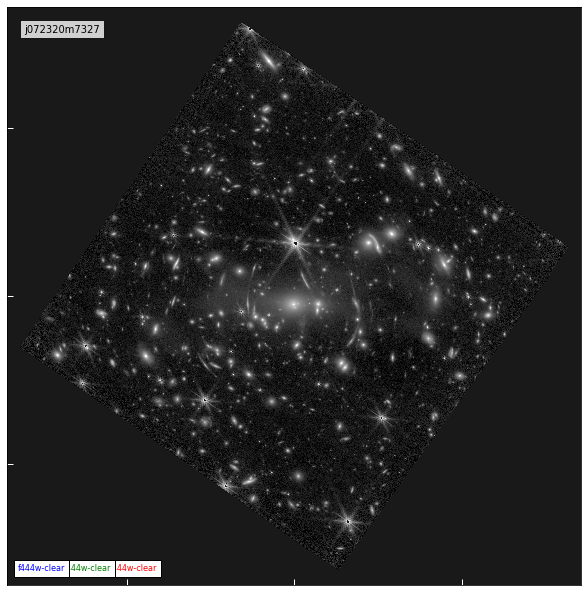

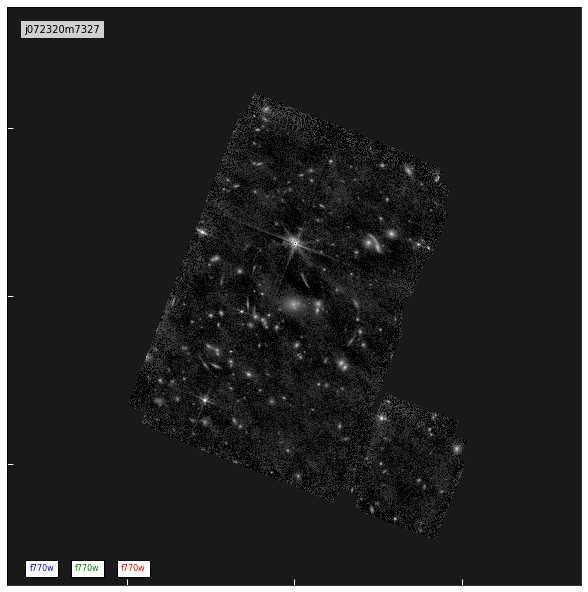

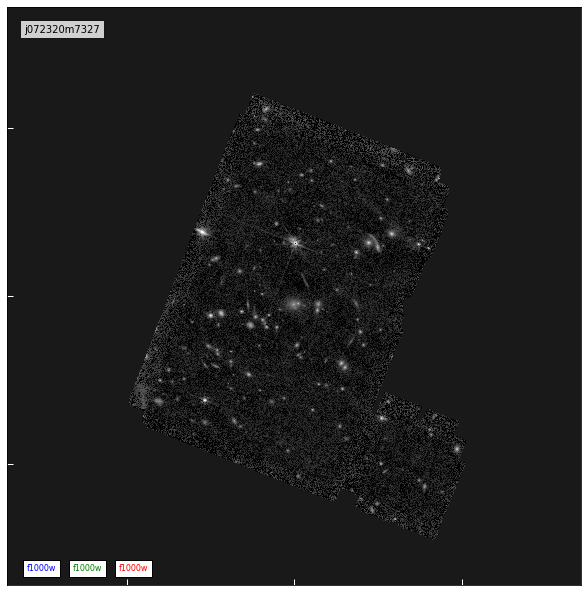

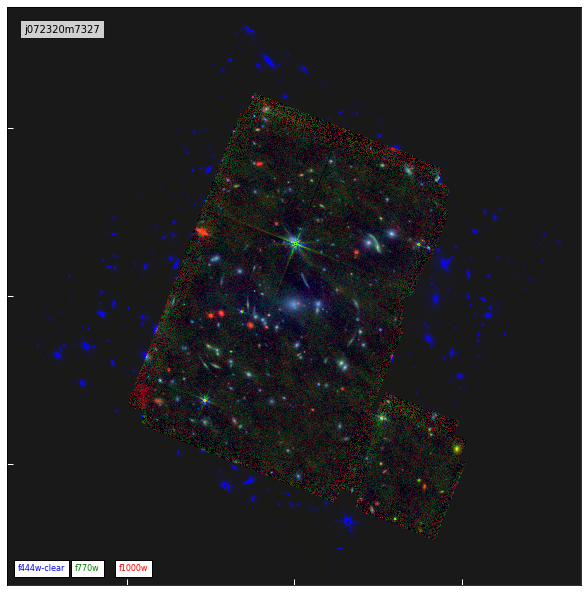

In [154]:
# RGB image
for i in range(3):
    _ = auto_script.field_rgb(root, show_ir=False, xsize=8,
                          filters=['f444w-clear','f770w','f1000w'][i:i+1],
                          rgb_scl=[4,3,1],
                          scl = 4,
                          HOME_PATH=None,
                         )
_ = auto_script.field_rgb(root, show_ir=False, xsize=8,
                          filters=['f444w-clear','f770w','f1000w'],
                          rgb_scl=[4,3,1],
                          scl = 4,
                          HOME_PATH=None,
                         )